# Exoplanets

In [38]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Sklearn Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score

An exoplanet is a planet that orbits a star outside our solar system. Some exoplanets don't orbit stars but rather some galactic center, these are called "rogue planets". This data doesn't have any information on "rogue" planets.

The dataset I'll be using is from Caltech and NASA, collected from the Kepler missions. The data consists of KOI's, or Kepler Objects of Interest. There are several columns, one of which being the status of a certain KOI being an exoplanet, with values Candidate, Confirmed, or False Positive. We will use this data to train a model to predict a KOI's likelihood of being an exoplanet.

## Data Exploration

### Data Cleaning

In [2]:
planet = pd.read_csv("nasa_exo_2022.csv")

In [3]:
planet.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


Let's rename some columns, the dataset came with a more descriptive column naming scheme so were just gonna use that, and condense some of the names

In [4]:
planet = planet.rename(columns={
'koi_disposition':'archiveDisposition',
'koi_pdisposition':'DispositionUsingKeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit-LikeFalsePositiveFlag',
'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
'koi_period':'OrbitalPeriod(days)',
'koi_period_err1':'OrbitalPeriodUpperUnc(days)',
'koi_period_err2':'OrbitalPeriodLowerUnc(days)',
'koi_time0bk':'TransitEpoch(BKJD)',
'koi_time0bk_err1':'TransitEpochUpperUnc(BKJD)',
'koi_time0bk_err2':'TransitEpochLowerUnc(BKJD)',
'koi_impact':'ImpactParameter',
'koi_impact_err1':'ImpactParameterUpperUnc',
'koi_impact_err2':'ImpactParameterLowerUnc',
'koi_duration':'TransitDuration(hrs)',
'koi_duration_err1':'TransitDurationUpperUnc(hrs)',
'koi_duration_err2':'TransitDurationLowerUnc(hrs)',
'koi_depth':'TransitDepth(ppm)',
'koi_depth_err1':'TransitDepthUpperUnc(ppm)',
'koi_depth_err2':'TransitDepthLowerUnc(ppm)',
'koi_prad':'PlanetaryRadius(Earthradii)',
'koi_prad_err1':'PlanetaryRadiusUpperUnc(Earthradii)',
'koi_prad_err2':'PlanetaryRadiusLowerUnc(Earthradii)',
'koi_teq':'EquilibriumTemperature(K)',
'koi_teq_err1':'EquilibriumTemperatureUpperUnc(K)',
'koi_teq_err2':'EquilibriumTemperatureLowerUnc(K)',
'koi_insol':'InsolationFlux(Earthflux)',
'koi_insol_err1':'InsolationFluxUpperUnc(Earthflux)',
'koi_insol_err2':'InsolationFluxLowerUnc(Earthflux)',
'koi_model_snr':'TransitSignal-to-Nois',
'koi_tce_plnt_num':'TCEPlanetNumber',
'koi_tce_delivname':'TCEDeliver',
'koi_steff':'EffectiveTemperature(K)',
'koi_steff_err1':'EffectiveTemperatureUpperUnc(K)',
'koi_steff_err2':'EffectiveTemperatureLowerUnc(K)',
'koi_slogg':'SurfaceGravity(log10(cm/s**2))',
'koi_slogg_err1':'SurfaceGravityUpperUnc(log10(cm/s**2))',
'koi_slogg_err2':'SurfaceGravityLowerUnc(log10(cm/s**2))',
'koi_srad':'Radius(Solarradii)',
'koi_srad_err1':'RadiusUpperUnc(Solarradii)',
'koi_srad_err2':'RadiusLowerUnc(Solarradii)',
'ra':'RA(decimaldegrees)',
'dec':'Dec(decimaldegrees)',
'koi_kepmag':'Kepler-band(mag)'
})

Full disclosure, I am not an astronomer, I just think space is cool. I need to define somethings for my own sake.
- Unc means uncertainty, most measures have uncertainty upper and lower bounds, so perhaps we can incorporate this in some way.
- BKJD is the Barycentric Kepler Julian Date which is the Julian Date (JD) corrected for differences in the Earth's position with respect to the barycentre of the Solar System.
    - The Julian Date is very simple, Jan 1st is the number 001, and december 31st is the number 365, July 29th(my birthday) is 210.
    - The barycentre of the Solar System is the center of mass of every object in the solar system combined. Our solar system's barycenter constantly changes position. Its position depends on where the planets are in their orbits. The solar system's barycenter can range from being near the center of the sun to being outside the surface of the sun.
- Solar Radius - Solar radius is a unit of distance used to express the size of stars in astronomy relative to the Sun. The solar radius is usually defined as the radius to the layer in the Sun's photosphere. 1 solar radius = 6.957 * 10^8 meters
- Earth flux, I couldn't find too much on this one but, solar flux just outside Earth's atmosphere is referred to as the “solar constant” and has a value of approximately 1373 W m− 2, where solar flux is a measure of how much light energy is being radiated in a given area.

You learn something new everyday!

In [5]:
planet["DispositionUsingKeplerData"].value_counts()

FALSE POSITIVE    4847
CANDIDATE         4717
Name: DispositionUsingKeplerData, dtype: int64

In [6]:
planet["PossibleExoplanet"] = planet["DispositionUsingKeplerData"].apply(lambda x : 1 if x == 'CANDIDATE' else 0)

In [7]:
planet["archiveDisposition"].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2668
CANDIDATE         2057
Name: archiveDisposition, dtype: int64

In [8]:
planet["ConfirmedExoplanet"] = planet["archiveDisposition"].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

In [9]:
planet.head()

,kepid,kepoi_name,kepler_name,archiveDisposition,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,koi_fpflag_ss,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,...,SurfaceGravityUpperUnc(log10(cm/s**2)),SurfaceGravityLowerUnc(log10(cm/s**2)),Radius(Solarradii),RadiusUpperUnc(Solarradii),RadiusLowerUnc(Solarradii),RA(decimaldegrees),Dec(decimaldegrees),Kepler-band(mag),PossibleExoplanet,ConfirmedExoplanet
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1,2
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1,2
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,1,1
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1,2


In [10]:
planet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 51 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   kepid                                                  9564 non-null   int64  
 1   kepoi_name                                             9564 non-null   object 
 2   kepler_name                                            2670 non-null   object 
 3   archiveDisposition                                     9564 non-null   object 
 4   DispositionUsingKeplerData                             9564 non-null   object 
 5   DispositionScore                                       8054 non-null   float64
 6   NotTransit-LikeFalsePositiveFlag                       9564 non-null   int64  
 7   koi_fpflag_ss                                          9564 non-null   int64  
 8   CentroidOffsetFalsePositiveFlag                 

We can definitely drop some of these columns. Some have no info, lots of missing info, or just info we aren't going to use, such as the flags that are categorical and are hard to find the meaning of.

In [11]:
planet = planet.drop(columns=['kepler_name','kepoi_name','EquilibriumTemperatureUpperUnc(K)',
                 'EquilibriumTemperatureLowerUnc(K)','archiveDisposition','DispositionUsingKeplerData',
                 'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliver'])

In [12]:
planet.isna().any()

kepid                                     False
DispositionScore                           True
OrbitalPeriod(days)                       False
OrbitalPeriodUpperUnc(days)                True
OrbitalPeriodLowerUnc(days)                True
TransitEpoch(BKJD)                        False
TransitEpochUpperUnc(BKJD)                 True
TransitEpochLowerUnc(BKJD)                 True
ImpactParameter                            True
ImpactParameterUpperUnc                    True
ImpactParameterLowerUnc                    True
TransitDuration(hrs)                      False
TransitDurationUpperUnc(hrs)               True
TransitDurationLowerUnc(hrs)               True
TransitDepth(ppm)                          True
TransitDepthUpperUnc(ppm)                  True
TransitDepthLowerUnc(ppm)                  True
PlanetaryRadius(Earthradii)                True
PlanetaryRadiusUpperUnc(Earthradii)        True
PlanetaryRadiusLowerUnc(Earthradii)        True
EquilibriumTemperature(K)               

We can't have any na values, perhaps I can revisit going column by column and doing some column-wise data cleaning, but for now I think its safe to drop all the na values. I would assume exoplanets have many different features so averaging columns for example wouldn't be the best option.

In [13]:
planet = planet.dropna()

In [14]:
planet.shape

(7803, 40)

Were left with 7803 observations and 40 predictors, that's pretty good!

### Data Viz

(array([6097.,  811.,  392.,  190.,   89.,   60.,   36.,   16.,   12.,
           9.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <BarContainer object of 10 artists>)

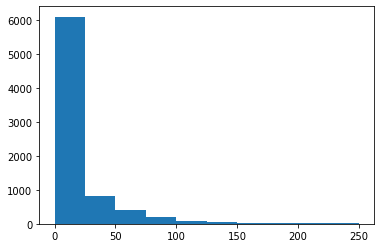

In [15]:
plt.hist(planet["PlanetaryRadius(Earthradii)"], range = [0,250])

I had to zoom in many times to get to this level, and its pretty clear that a lot of the objects are really small, and only a small number of them are quite large.

(array([2.628e+03, 6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <BarContainer object of 10 artists>)

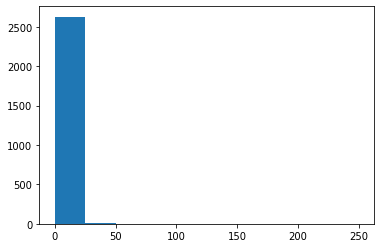

In [16]:
plt.hist(planet[planet["ConfirmedExoplanet"] == 2]["PlanetaryRadius(Earthradii)"], range = [0,250])

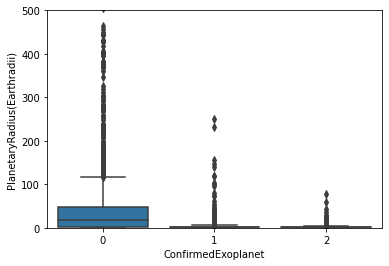

In [17]:
sns.boxplot(x="ConfirmedExoplanet", y="PlanetaryRadius(Earthradii)", data = planet)
plt.ylim(0, 500)
plt.show()

Even the confirmed exoplanets are quite small, actually the smallest of all the objects.

(array([   7.,   13.,    7.,    8.,   72.,  102.,  327., 1853., 5352.,
          62.]),
 array([0.047 , 0.5787, 1.1104, 1.6421, 2.1738, 2.7055, 3.2372, 3.7689,
        4.3006, 4.8323, 5.364 ]),
 <BarContainer object of 10 artists>)

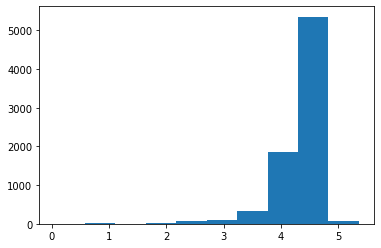

In [18]:
plt.hist(planet["SurfaceGravity(log10(cm/s**2))"])

<AxesSubplot:xlabel='ConfirmedExoplanet', ylabel='TransitDuration(hrs)'>

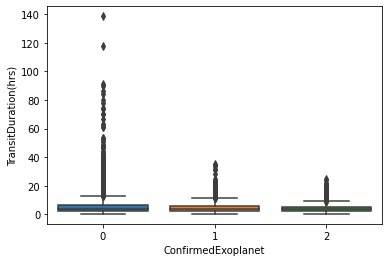

In [19]:
sns.boxplot(x="ConfirmedExoplanet", y="TransitDuration(hrs)", data = planet)

(0.0, 100000.0)

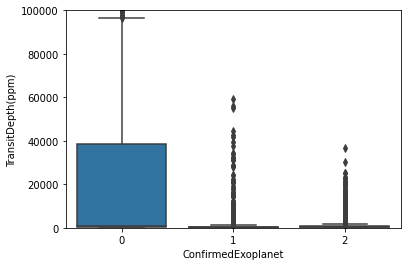

In [20]:

sns.boxplot(x="ConfirmedExoplanet", y="TransitDepth(ppm)", data = planet)
plt.ylim(0, 100000)


The transit depth is "the fraction of stellar flux lost at the minimum of the planetary transit", so essentially how bright/dim the light from a star became after the planet passed in front of it.

It seems this is much more concentrated in lower ppm for confirmed and candidate exoplanets than the false positive ones, which have a huge range. This will likely be a main predictor in the model.

(0.0, 8000.0)

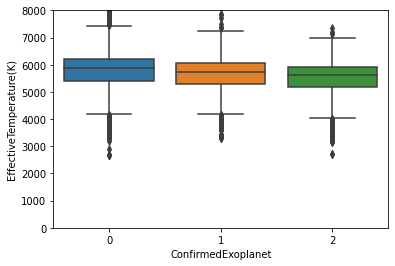

In [21]:
sns.boxplot(x="ConfirmedExoplanet", y="EffectiveTemperature(K)", data = planet)
plt.ylim(0,8000)

Temperature doesn't really seem to have an effect, the mean for all the KOIs are about the same.

## Classification

In [22]:
def evaluation(y_test, y_pred):
    
    # Print Accuracy, Recall, F1 Score, and Precision metrics.
    print('Evaluation:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    
    # Print Confusion Matrix
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_test, y_pred).ravel())
    
# Function Prints best parameters for GridSearchCV
def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_)) 

In [23]:
planet

,kepid,DispositionScore,OrbitalPeriod(days),OrbitalPeriodUpperUnc(days),OrbitalPeriodLowerUnc(days),TransitEpoch(BKJD),TransitEpochUpperUnc(BKJD),TransitEpochLowerUnc(BKJD),ImpactParameter,ImpactParameterUpperUnc,...,SurfaceGravityUpperUnc(log10(cm/s**2)),SurfaceGravityLowerUnc(log10(cm/s**2)),Radius(Solarradii),RadiusUpperUnc(Solarradii),RadiusLowerUnc(Solarradii),RA(decimaldegrees),Dec(decimaldegrees),Kepler-band(mag),PossibleExoplanet,ConfirmedExoplanet
0,10797460,1.000,9.488036,2.780000e-05,-2.780000e-05,170.538750,0.002160,-0.002160,0.146,0.318,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1,2
1,10797460,0.969,54.418383,2.480000e-04,-2.480000e-04,162.513840,0.003520,-0.003520,0.586,0.059,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1,2
2,10811496,0.000,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,0.969,5.126,...,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,1,1
3,10848459,0.000,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,...,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0
4,10854555,1.000,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,0.701,0.235,...,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,0.000,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,...,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082,0,0
9560,10128825,0.497,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,...,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757,1,1
9561,10147276,0.021,0.681402,2.430000e-06,-2.430000e-06,132.181750,0.002850,-0.002850,0.147,0.309,...,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385,0,0
9562,10155286,0.092,333.486169,4.240000e-03,-4.240000e-03,153.615010,0.005070,-0.005070,0.214,0.255,...,0.030,-0.027,7.824,0.223,-1.896,296.76288,47.145142,10.998,1,1


In [24]:
planet = planet.drop(columns = ["kepid"])

In [25]:
predictors = planet.drop(columns=['PossibleExoplanet','ConfirmedExoplanet'])
y = planet["PossibleExoplanet"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(predictors, y, random_state=1, test_size=0.30)

In [27]:
scaler_tr = preprocessing.StandardScaler().fit(X_train)
scaler_ts = preprocessing.StandardScaler().fit(X_test)
X_tr_scaled = scaler_tr.transform(X_train)
X_tst_scaled = scaler_ts.transform(X_test)

### Logistic Regression

Logistice Regression is a very simple classification method. The model takes the form of 
$$p(x) = \frac{1}{1+ e^{\beta_0 + \beta_1x}}$$ where $$\beta_0$$ is the intercept, and $$\beta_1$$ is the slope of the log odds function as a function of x. The result is: ![logistic graph](images/log.jpeg)
As we can see, the points are fit into two classes, and compared to linear regression, the fit of f(x) is much tighter. The value $$\mu$$ is the boundary where the the classes are split. If we rewrite the equation above we get : $$p(x) = \frac{1}{1+ e^{-(x - \mu)/s}}$$ where s is a scaling parameter, basically, the larger value of s, the more spread out the distribution is.


I will start with a simple logistic regression, as a baseline. The parameters I will use are:
- C : This is the inverse of regularization strength. It will essentially reduce overfitting by penalizing larger values of the parameters. Large values will contribute less to the fit of the model and therefore reduce overfitting.
- max_iter : This is the max iterations used for the solvers to converge
- class_weight : from sklearn: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [28]:
# Logistic Regression Model
lr = LogisticRegression(C=100, max_iter=400, class_weight='balanced')

# Fitting Model to the train set
lr.fit(X_train, y_train)

# Predicting on the test set
y_pred = lr.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.8363947031183255
Recall: 0.8768595041322315
F1 Score: 0.8471057884231536
Precision: 0.8193050193050193

Confusion Matrix:
 TN,  FP, FN, TP
[ 897  234  149 1061]
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Let's try using the scaled data.

In [29]:
# Logistic Regression Model
lr = LogisticRegression(C=100, max_iter=400, class_weight='balanced')

# Fitting Model to the train set
lr.fit(X_tr_scaled, y_train)

# Predicting on the test set
y_pred = lr.predict(X_tst_scaled)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.954720205040581
Recall: 0.959504132231405
F1 Score: 0.956342668863262
Precision: 0.9532019704433498

Confusion Matrix:
 TN,  FP, FN, TP
[1074   57   49 1161]
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNN

K Nearest Neighbors essentially looks at each data points K nearest points, and uses their classification. The parameters I will use:
- n_neighbors : How many neighbors should be used for each point.
- metric : There are several different metrics to use for distance calculations, and hence finding the closest points. Examples : 'manhattan', 'cosine', 'minkowski'
- weights : There are different methods of determining weights of each point in a neighborhood. Uniform gives all the points equal weight whereas distance will give more weight to closer points in the neighborhood.

In [30]:
knn = KNeighborsClassifier(n_neighbors = 5, metric='manhattan',weights='uniform')

# Fitting Model to the train set
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.803929944468176
Recall: 0.8289256198347107
F1 Score: 0.8137931034482758
Precision: 0.799203187250996

Confusion Matrix:
 TN,  FP, FN, TP
[ 879  252  207 1003]


In [31]:
knn = KNeighborsClassifier(metric='manhattan',weights='uniform')

# Fitting Model to the train set
knn.fit(X_tr_scaled, y_train)

# Predicting on the test set
y_pred = knn.predict(X_tst_scaled)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.9461768475010679
Recall: 0.9413223140495868
F1 Score: 0.9475873544093179
Precision: 0.9539363484087102

Confusion Matrix:
 TN,  FP, FN, TP
[1076   55   71 1139]


It's pretty clear that the scaled data works the best.

### Trees

Trees aren't as sensitive to variance in the data, so scaling wont be necessary.

The basic idea behind decision trees are using the predictors to set thresholds, where each threshold is a node in the tree. Say all the exoplanets have a radius under 5 earth radii (I made this up) and most of the false positive objects have a radius over 5 earth radii. This is where we would create a node and "send down" observations.  
![Tree](images/tree_img.png)
For each KOI that is under 5 earth radii, we send that down one branch, and the ones over 5 are sent down another branch. The end result is a 'tree' with several nodes, as seen above. Finally the 'leaf' nodes (labeled A,B,C,D in the image) are the class in which a data point would belong. This is why I used the terminology "sending down the tree" because the training data is used to build these criterion, and the test data then classifies based on them. In our case there are only 2 possible classes, but there will still be multiple leaf nodes.

In [32]:
tree = DecisionTreeClassifier()

# Fitting Model to the train set
tree.fit(X_train, y_train)

# Predicting on the test set
y_pred = tree.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.9307988039299445
Recall: 0.9330578512396694
F1 Score: 0.9330578512396694
Precision: 0.9330578512396694

Confusion Matrix:
 TN,  FP, FN, TP
[1050   81   81 1129]


We can see that the tree performs quite well, but this is only one tree. Random forests combine multiple trees and classify that way.

Random Forests take the process described above and does it multiple times, so were left with multiple relatively uncorrelated trees. How are they uncorrelated you may ask:
 - Each tree uses randomly sampled data from the training data with replacement, a process known as bagging (bootstrap aggragation), so each tree is built on different "bootstrap" datasets. 
 - Each tree also has a subset of different predictors so they don't use all of the predictors in each, forcing different splits to be made, and making it so the trees don't see all of the features.

With these uncorrelated trees, we know that some are probably wrong, and some are right. When we feed the model data, it will use all the trees, where each tree has one vote, the class with the most votes is where the observation is classified to.

There are different criterion to use for making the split, and it based on minimizing a loss function.
- Gini : Evaluates split based on the 'purity' of the resulting	nodes, a value of 0 means that a node has 100% of one class, it is calulated as follows ![gini](images/gini.png) 

- Entropy : Pretty similar, evaluates the 'chaos' which is basically the impurity, it is just calculated differently, as shown below. A split is only performed if the resulting nodes entropies are smaller than the entropy of their parent node. ![entropy](images/entropy.png)

credit: [Medium Post](https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575)

- Log-loss: Similar to the above, it is just trying to minimize the following equation:

$$L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))$$

In [35]:
# n_estimators is the number of trees to use
forest = RandomForestClassifier(n_estimators=100, criterion='gini')

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.9611277231952157
Recall: 0.947107438016529
F1 Score: 0.9618128409567773
Precision: 0.9769820971867008

Confusion Matrix:
 TN,  FP, FN, TP
[1104   27   64 1146]


In [34]:
# n_estimators is the number of trees to use
forest = RandomForestClassifier(n_estimators=100, criterion='gini')

forest.fit(X_tr_scaled, y_train)

y_pred = forest.predict(X_tst_scaled)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.9594190516873131
Recall: 0.9479338842975207
F1 Score: 0.9602344077019673
Precision: 0.9728583545377438

Confusion Matrix:
 TN,  FP, FN, TP
[1099   32   63 1147]


Lastly, we can see if we can perform any better by tuning the parameters.

- max_depth: The maximum depth a tree can be built to, the depth is essentially the layers of a tree, just a root will be depth 0, a root with 2 children is depth 1, and if either of those children have children, the tree will have depth of 2 and so on.
- max_features: Recall that each tree in the forest is bult with a subset of predictors, this number determines the max amount to use for that subset
- oob_score : Whether to use out of bag samples to estimate the score, out of bag samples are the observations not chosen when creating the bootstrap samples.

In [36]:
# GridSearch Parameters
parameters = {
    'n_estimators': [10, 50, 100, 150, 200, 250],
    'max_depth': list(range(3, 14)),
    'criterion':['gini','entropy'],
    'max_features': list(range(5,25)),
    'oob_score':[False,True],
}

In [41]:
grid = RandomizedSearchCV(forest, parameters, cv=5, verbose = 1, n_iter = 10)

grid.fit(X_train, y_train)
y_test_grid = grid.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/p

In [42]:
grid.best_params_

{'oob_score': False,
 'n_estimators': 250,
 'max_features': 6,
 'max_depth': 10,
 'criterion': 'gini'}

In [44]:
# n_estimators is the number of trees to use
best_forest = RandomForestClassifier(n_estimators=250,max_depth=10 ,criterion='gini', max_features = 6, oob_score = False)

best_forest.fit(X_train, y_train)

y_pred = best_forest.predict(X_test)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.9589918838103375
Recall: 0.9462809917355371
F1 Score: 0.9597652975691533
Precision: 0.9736394557823129

Confusion Matrix:
 TN,  FP, FN, TP
[1100   31   65 1145]


In [45]:
best_forest.feature_importances_

array([0.44410012, 0.02228699, 0.01201707, 0.0116557 , 0.00723405,
       0.0081358 , 0.00774215, 0.01545735, 0.00517637, 0.00433212,
       0.00745636, 0.01141952, 0.01042586, 0.02487574, 0.00455811,
       0.00474472, 0.08128388, 0.05018753, 0.05253458, 0.02170745,
       0.01918921, 0.02443246, 0.01984561, 0.01477447, 0.0023956 ,
       0.00451939, 0.03164273, 0.03536682, 0.00471355, 0.00410168,
       0.0048178 , 0.00429756, 0.00468756, 0.00438286, 0.00557361,
       0.00331104, 0.00461657])

In [51]:
planet.columns

Index(['DispositionScore', 'OrbitalPeriod(days)',
       'OrbitalPeriodUpperUnc(days)', 'OrbitalPeriodLowerUnc(days)',
       'TransitEpoch(BKJD)', 'TransitEpochUpperUnc(BKJD)',
       'TransitEpochLowerUnc(BKJD)', 'ImpactParameter',
       'ImpactParameterUpperUnc', 'ImpactParameterLowerUnc',
       'TransitDuration(hrs)', 'TransitDurationUpperUnc(hrs)',
       'TransitDurationLowerUnc(hrs)', 'TransitDepth(ppm)',
       'TransitDepthUpperUnc(ppm)', 'TransitDepthLowerUnc(ppm)',
       'PlanetaryRadius(Earthradii)', 'PlanetaryRadiusUpperUnc(Earthradii)',
       'PlanetaryRadiusLowerUnc(Earthradii)', 'EquilibriumTemperature(K)',
       'InsolationFlux(Earthflux)', 'InsolationFluxUpperUnc(Earthflux)',
       'InsolationFluxLowerUnc(Earthflux)', 'TransitSignal-to-Nois',
       'TCEPlanetNumber', 'EffectiveTemperature(K)',
       'EffectiveTemperatureUpperUnc(K)', 'EffectiveTemperatureLowerUnc(K)',
       'SurfaceGravity(log10(cm/s**2))',
       'SurfaceGravityUpperUnc(log10(cm/s**2))',
   

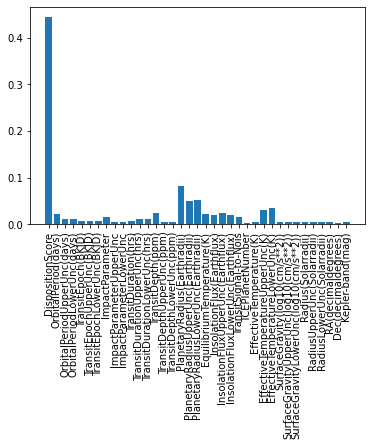

In [57]:
plt.bar(X_train.columns, best_forest.feature_importances_)
plt.xticks(rotation= 90)
plt.show()

Looks like the Disposition Score is by far the most important, it is a score from 0 to 1 that indicates the confidence in the flag given, the flag being FALSE POSITIVE or CANDIDATE. Of course this is the strongest, we should actually take it out because it is giving too much away.

While were at it, we should remove all the uncertainty values, they aren't actual measurements but rather uncertainties on the actual measurements of the KOI's

In [58]:
planet.columns

Index(['DispositionScore', 'OrbitalPeriod(days)',
       'OrbitalPeriodUpperUnc(days)', 'OrbitalPeriodLowerUnc(days)',
       'TransitEpoch(BKJD)', 'TransitEpochUpperUnc(BKJD)',
       'TransitEpochLowerUnc(BKJD)', 'ImpactParameter',
       'ImpactParameterUpperUnc', 'ImpactParameterLowerUnc',
       'TransitDuration(hrs)', 'TransitDurationUpperUnc(hrs)',
       'TransitDurationLowerUnc(hrs)', 'TransitDepth(ppm)',
       'TransitDepthUpperUnc(ppm)', 'TransitDepthLowerUnc(ppm)',
       'PlanetaryRadius(Earthradii)', 'PlanetaryRadiusUpperUnc(Earthradii)',
       'PlanetaryRadiusLowerUnc(Earthradii)', 'EquilibriumTemperature(K)',
       'InsolationFlux(Earthflux)', 'InsolationFluxUpperUnc(Earthflux)',
       'InsolationFluxLowerUnc(Earthflux)', 'TransitSignal-to-Nois',
       'TCEPlanetNumber', 'EffectiveTemperature(K)',
       'EffectiveTemperatureUpperUnc(K)', 'EffectiveTemperatureLowerUnc(K)',
       'SurfaceGravity(log10(cm/s**2))',
       'SurfaceGravityUpperUnc(log10(cm/s**2))',
   

In [64]:
exo = planet.drop(["DispositionScore", 'PlanetaryRadiusUpperUnc(Earthradii)',
'PlanetaryRadiusLowerUnc(Earthradii)', 'InsolationFluxUpperUnc(Earthflux)','InsolationFluxLowerUnc(Earthflux)',
'EffectiveTemperatureUpperUnc(K)', 'EffectiveTemperatureLowerUnc(K)', 'SurfaceGravityUpperUnc(log10(cm/s**2))',
'SurfaceGravityLowerUnc(log10(cm/s**2))','RadiusUpperUnc(Solarradii)', 'RadiusLowerUnc(Solarradii)','OrbitalPeriodUpperUnc(days)', 
'OrbitalPeriodLowerUnc(days)','TransitEpochUpperUnc(BKJD)','TransitEpochLowerUnc(BKJD)','ImpactParameterUpperUnc', 'ImpactParameterLowerUnc',
'TransitDurationUpperUnc(hrs)','TransitDurationLowerUnc(hrs)','TransitDepthUpperUnc(ppm)', 'TransitDepthLowerUnc(ppm)'], axis = 1)

In [65]:
exo.columns

Index(['OrbitalPeriod(days)', 'TransitEpoch(BKJD)', 'ImpactParameter',
       'TransitDuration(hrs)', 'TransitDepth(ppm)',
       'PlanetaryRadius(Earthradii)', 'EquilibriumTemperature(K)',
       'InsolationFlux(Earthflux)', 'TransitSignal-to-Nois', 'TCEPlanetNumber',
       'EffectiveTemperature(K)', 'SurfaceGravity(log10(cm/s**2))',
       'Radius(Solarradii)', 'RA(decimaldegrees)', 'Dec(decimaldegrees)',
       'Kepler-band(mag)', 'PossibleExoplanet', 'ConfirmedExoplanet'],
      dtype='object')

In [66]:
predictors = exo.drop(columns=['PossibleExoplanet','ConfirmedExoplanet'])
y = exo["PossibleExoplanet"]

X_train, X_test, y_train, y_test = train_test_split(predictors, y, random_state=1, test_size=0.30)

In [67]:
scaler_tr = preprocessing.StandardScaler().fit(X_train)
scaler_ts = preprocessing.StandardScaler().fit(X_test)
X_tr_scaled = scaler_tr.transform(X_train)
X_tst_scaled = scaler_ts.transform(X_test)

In [68]:
# n_estimators is the number of trees to use
best_forest = RandomForestClassifier(n_estimators=250,max_depth=10 ,criterion='gini', max_features = 6, oob_score = False)

best_forest.fit(X_train, y_train)

y_pred = best_forest.predict(X_test)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.8752669799231098
Recall: 0.9
F1 Score: 0.8817813765182188
Precision: 0.8642857142857143

Confusion Matrix:
 TN,  FP, FN, TP
[ 960  171  121 1089]


There are worse results, but there are no longer any predictors that hint at the ranking (the metric was calculated AFTER the classification).

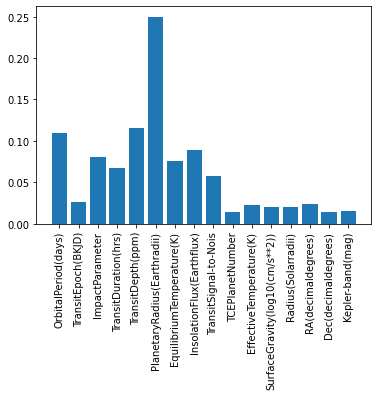

In [69]:
plt.bar(X_train.columns, best_forest.feature_importances_)
plt.xticks(rotation= 90)
plt.show()

It appears that Planetary Radius is the most important feature by some margin. The EDA I performed showed that confirmed and candidate exoplanets were in a much tighter range than the other KOIs, which ranged from very small to very large (relatively) objects.

I also predicted that Transit Depth would be an important predictor, and it is the second or third most important

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb883b55-1526-4482-aad8-9ba82b613495' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>